# Implement smooth covariates 

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions.mvn_degen import MulitvariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

rng = np.random.default_rng(42)

# load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

In [2]:
df

,age,bmi
0,0.03,13.235289
1,0.04,12.438775
2,0.04,14.541775
3,0.04,11.773954
4,0.04,15.325614
...,...,...
7289,21.45,19.329493
7290,21.47,21.562722
7291,21.54,23.355726
7292,21.68,24.869006


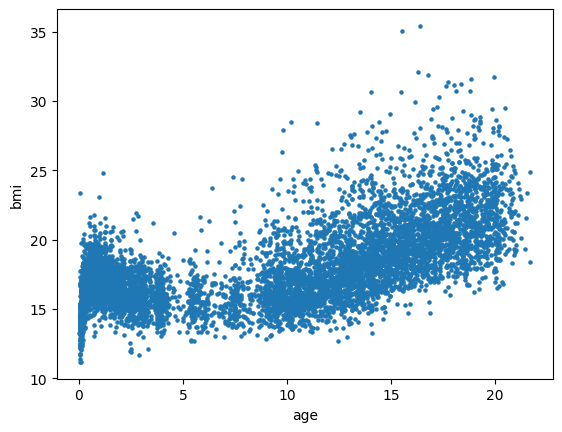

In [3]:
# plot the data
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [4]:
# set up design matrix 
X = tiger.Obs(name = "X_loc")
X.smooth(data = df["age"].to_numpy())

# set up hyperparameters for the beta_scale  
tau_a = tiger.Hyper(0.01, name="tau_a")
tau_b = tiger.Hyper(0.01, name="tau_b")
tau_dist = tiger.Dist(tfd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=jnp.log(100), distribution=tau_dist, function=jnp.exp, name="tau")

# set up hyperparameters
beta_loc = tiger.Hyper(np.zeros(X.smooth_dim), name="beta_loc")

# set up parameters 
beta_dist = tiger.Dist(MulitvariateNormalDegenerate, loc=beta_loc, scale=tau)
beta = tiger.Param(value=np.zeros(X.smooth_dim), distribution=beta_dist, name="beta")

# set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=jnp.log(10), distribution=sigma_dist, function=jnp.exp, name="sigma")

# set up the linear predictor 
lpred = tiger.Lpred(Obs=X, beta=beta)

# set up response distribution
response_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [9]:
graph = tiger.ModelGraph(Model=m)
graph.build_graph()

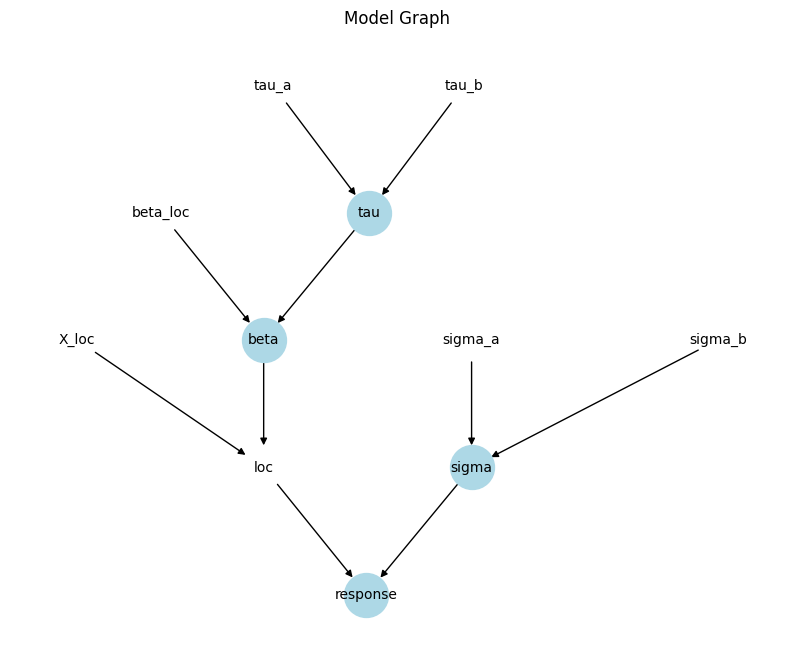

In [10]:
graph.visualize_graph()

## Inference with BBVI

In [32]:
q = bbvi.Bbvi(Graph=graph, num_samples=64, num_iterations=20000, key=27)

In [33]:
q.run_bbvi(step_size=0.05, threshold=1e-5, chunk_size=25)

(Array(-15717.127, dtype=float32),
 {'tau': {'mu': Array([-3.9215124], dtype=float32),
   'cov': Array([[0.84090716]], dtype=float32)},
  'sigma': {'mu': Array([0.731847], dtype=float32),
   'cov': Array([[6.168937e-05]], dtype=float32)},
  'beta': {'mu': Array([17.402699, 16.17945 , 15.313386, 16.154268, 15.609689, 15.61301 ,
          15.619525, 15.541464, 15.887172, 16.326197, 16.520008, 16.765598,
          16.767006, 17.42718 , 17.707504, 18.147861, 18.629835, 19.224339,
          19.449987, 19.941298, 20.46126 , 20.965315, 21.486948, 21.57397 ,
          21.8269  , 22.064938], dtype=float32),
   'cov': Array([[ 6.74018916e-03,  5.11593185e-03,  1.32193929e-03,
           -3.57642956e-03,  3.13797570e-03,  5.20944595e-03,
            4.26320912e-04,  4.70023463e-03,  1.63994916e-03,
            6.78632408e-04, -1.70175894e-03, -1.75218840e-04,
            2.17655452e-05,  7.06530293e-04,  1.01965317e-03,
            8.99310980e-04, -2.27154489e-03,  3.09908623e-03,
            2.5

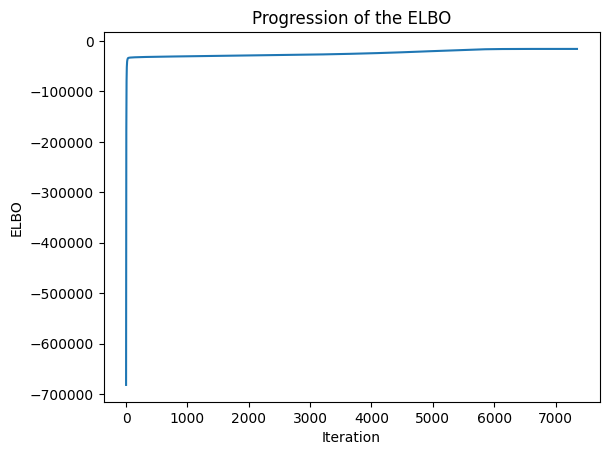

In [34]:
q.plot_elbo()

## Visualize the regression line 

In [35]:
# plot the regression line 
b = q.opt_variational_params["beta"]["mu"]

y = X.design_matrix @ b

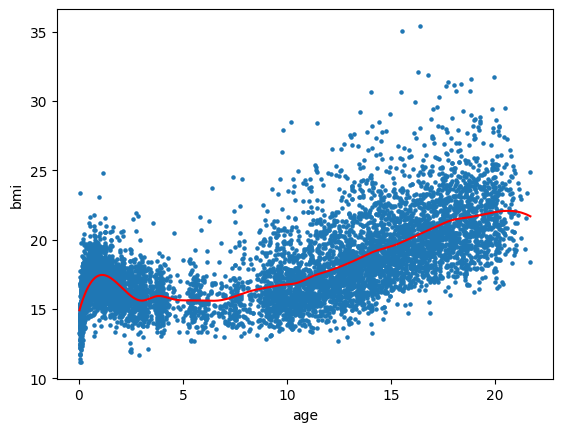

In [36]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [37]:
tau = q.opt_variational_params["tau"]["mu"]

In [39]:
1/jnp.exp(tau)

Array([50.476727], dtype=float32)